Analyses properties of decorrelation and whitening methods for FC and Convolutional cases.

In [1]:
import numpy as np
import torch
from decorrelation.decorrelation import Decorrelation, lower_triangular, DecorrelationPatch2d # covariance, DecorrelationPatch2d, DecorrelationFC, lower_triangular
import matplotlib.pyplot as plt

# automatic reloading of modules when they change
%load_ext autoreload
%autoreload 2

We start by showing effective decorrelation of correlated input

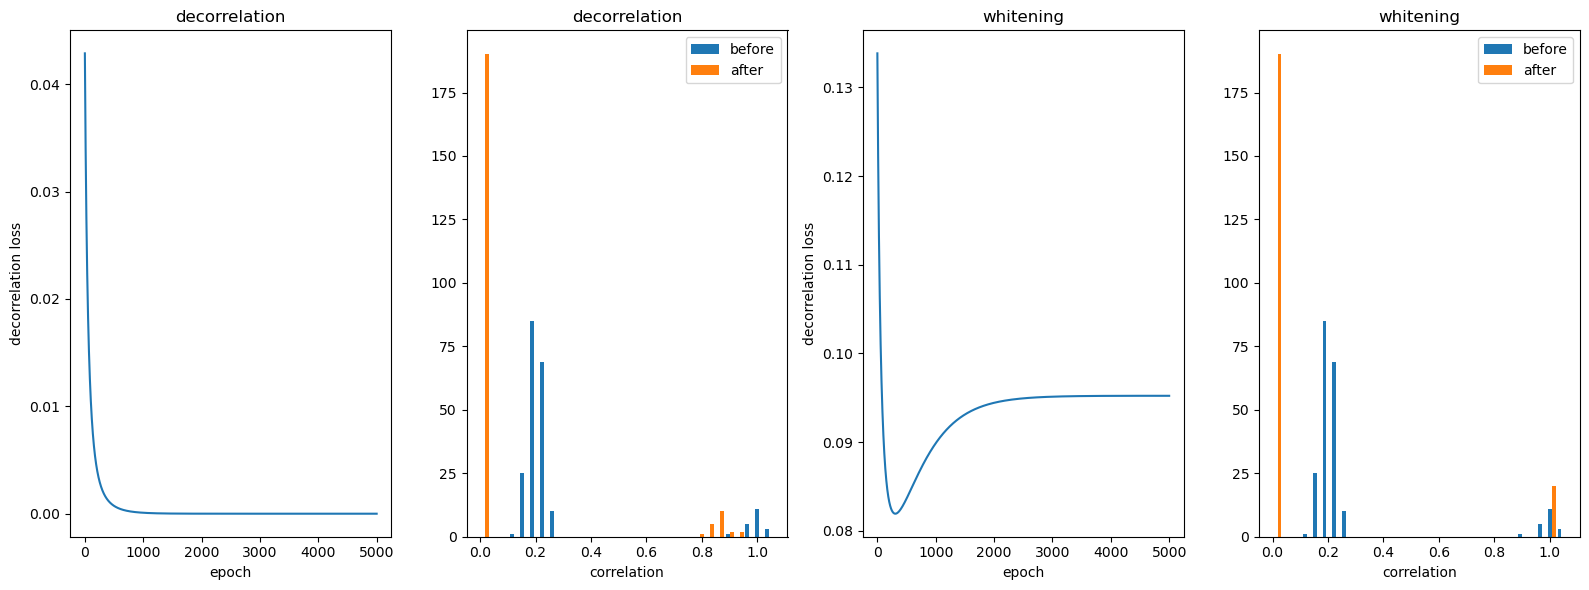

In [17]:
num_samples=1000
num_features=20
num_epochs=1000

# generate correlated data
d = torch.distributions.MultivariateNormal(torch.zeros(num_features), 0.8 * torch.eye(num_features) + 0.2 * torch.ones((num_features, num_features)))
data = d.sample((num_samples,))

plt.figure(figsize=(16,6))
for w in range(2):

    # create a fully connected decorrelator
    model = Decorrelation(num_features, whiten=(w==1)) # NOTE: the whitening constraint is only realised weakly due to the off-diagonal constraints; we observe a weak tendency to unit variance

    # correlation matrix before training
    X = model.forward(data)
    A1 = (X.T @ X) / len(X)

    # train decorrelator
    L = np.zeros(num_epochs)
    for i in range(num_epochs):
        y = model.forward(data)
        L[i] = model.update()
        model.R -= 1e-3 * model.R.grad
        # print(f'iteration {i}\tdecorrelation loss: {L[i]:.3f}')

    # correlation matrix before training
    X = model.forward(data)
    A2 = (X.T @ X) / len(X)

    plt.subplot(1,4,1+2*w)
    plt.plot(L)
    plt.title('whitening' if w==1 else 'decorrelation') 
    plt.ylabel('decorrelation loss')
    plt.xlabel('epoch')
    plt.subplot(1,4,2+2*w)
    plt.hist([lower_triangular(A1, offset=0), lower_triangular(A2, offset=0)], bins=30, label=['before', 'after'])
    plt.legend()
    plt.xlabel('correlation')
    plt.title('whitening' if w==1 else 'decorrelation') 
    plt.legend()
    plt.tight_layout()

In [3]:
model.R = torch.nn.Parameter(0.5*torch.eye(model.R.shape[0]))
X = model.forward(data)
A3 = (X.T @ X) / len(X)
print(f'trivial solution: loss: {model.update():.3f}; off-diagonal: {torch.mean(torch.abs(lower_triangular(A3, offset=-1))):.3f}; diagonal: {torch.mean(torch.abs(torch.diag(A3))):.3f}')

trivial solution: loss: 0.008; off-diagonal: 0.047; diagonal: 0.247


Decorrelation of correlated input using DecorrelationPatch2d: decorrelate patches and map back to feature maps; why are all resulting values tiny? (also diagonal)

In [12]:
# generate [N, M] correlated input
num_examples=100
num_channels=2
height=20
width=20
num_features=num_channels*height*width
kernel_size=(5,5)
whiten = False

d = torch.distributions.MultivariateNormal(torch.zeros(num_features), 0.1 * torch.eye(num_features) + 0.9 * torch.ones((num_features, num_features)))
data = d.sample((num_examples,)).reshape(num_examples,num_channels,height,width)

# create a convolutional decorrelator
model = DecorrelationPatch2d(2, kernel_size=kernel_size, whiten=whiten)

# covariance matrix before training
X = model.forward(data).view(data.shape[0],-1)
B1 = (X.T @ X) / len(X)

# train decorrelator
L = np.zeros(1000)
for i in range(1000):
    y = model.forward(data)
    L[i] = model.update()
    model.R -= 1e-3 * model.R.grad
    # print(f'iteration {i}\tdecorrelation loss: {L[i]:.3f}')

# covariance matrix after training
X = model.forward(data).view(data.shape[0],-1)
B2 = (X.T @ X) / len(X)

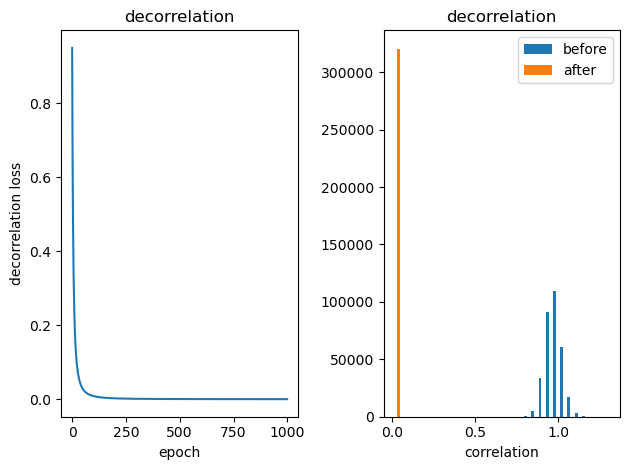

In [13]:
plt.subplot(1,2,1)
plt.plot(L)
plt.ylabel('decorrelation loss')
plt.xlabel('epoch')
plt.title('whitening' if whiten else 'decorrelation')   
plt.subplot(1,2,2)
plt.hist([lower_triangular(B1, offset=0), lower_triangular(B2, offset=0)], bins=30, label=['before', 'after'])
plt.legend()
plt.xlabel('correlation')
plt.title('whitening' if whiten else 'decorrelation') 
plt.legend();
plt.tight_layout()


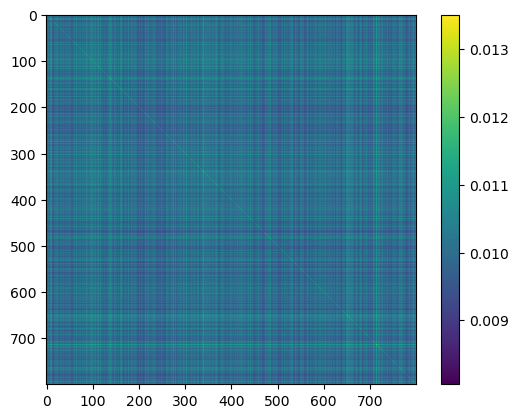

In [16]:
plt.imshow(B2)
plt.colorbar();

To do:
- experiment can be used if current approach works. Do we have any guarantee of decorrelated input if average over patches? and if we take only center pixel? We can check by extracting the patches for the created output again and compute covariances
- reimplement code sander as starting point also for comparison